In [1]:
print_imports()

Loaded modules:
Numpy                np              1.14.0
Pandas               pd              0.22.0
Keras                ks              2.1.3

Matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             N/A
matplotlib.image     mpimg           N/A
Seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      NOT LOADED      N/A

pyspark              NOT LOADED      N/A


In [2]:
import os
import json
import copy

In [3]:
from pprint import pprint
import pprint
import os, shutil

<h4>Paths</h4>

In [5]:

root_path = "/media/batman/Windows/Dropbox/DATA/cats_dogs_small"

def my_splitpath(path, maxdepth=20):
     ( head, tail ) = os.path.split(path)
     return my_splitpath(head, maxdepth - 1) + [ tail ] \
         if maxdepth and head and head != path \
         else [ head or tail ]

data_dict = dict()

print("Files are organized as follows\n")

print("{:<10} {:<70} {}".format("files", "path", "key"))
for (path, dirs, files) in os.walk(root_path):
    
    files = [file for file in files]
    
    if len(files) > 0:
        total_split = my_splitpath(path)
        variablename = "_".join(total_split[-2:])
        print("{:<10} {:<70} {}".format(len(files), "/".join(total_split),variablename))
        data_dict[variablename] = dict()
        data_dict[variablename]['path'] = path
        data_dict[variablename]['file_count'] = len(files)

        
#pprint(data_dict)
path_test  = os.path.split(data_dict['test_cats']['path'])[0]
path_train   = os.path.split(data_dict['train_cats']['path'])[0]
path_val = os.path.split(data_dict['validation_cats']['path'])[0]
print("path_test", path_test)
print("path_val",path_val)
print("path_train",path_train)
#for k in data_dict:
#    print(k)


Files are organized as follows

files      path                                                                   key
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/test/cats          test_cats
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/test/dogs          test_dogs
1000       //media/batman/Windows/Dropbox/DATA/cats_dogs_small/train/cats         train_cats
1000       //media/batman/Windows/Dropbox/DATA/cats_dogs_small/train/dogs         train_dogs
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation/cats    validation_cats
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation/dogs    validation_dogs
path_test /media/batman/Windows/Dropbox/DATA/cats_dogs_small/test
path_val /media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation
path_train /media/batman/Windows/Dropbox/DATA/cats_dogs_small/train


<h4>Get a random selection</h4>

In [6]:
display_images = list()

# Get cats
this_path = data_dict["train_cats"]['path']
these_files = [os.path.join(this_path,f) for f in os.listdir(this_path) if os.path.isfile(os.path.join(this_path, f))]
np.random.shuffle(these_files)
display_images += these_files[0:4]

# Get dogs
this_path = data_dict["train_dogs"]['path']
these_files = [os.path.join(this_path,f) for f in os.listdir(this_path) if os.path.isfile(os.path.join(this_path, f))]
np.random.shuffle(these_files)
display_images += these_files[0:4]

# for i in display_images:
#     print(i)

#print(display_images)

<h4>Display some cats/docs</h4>

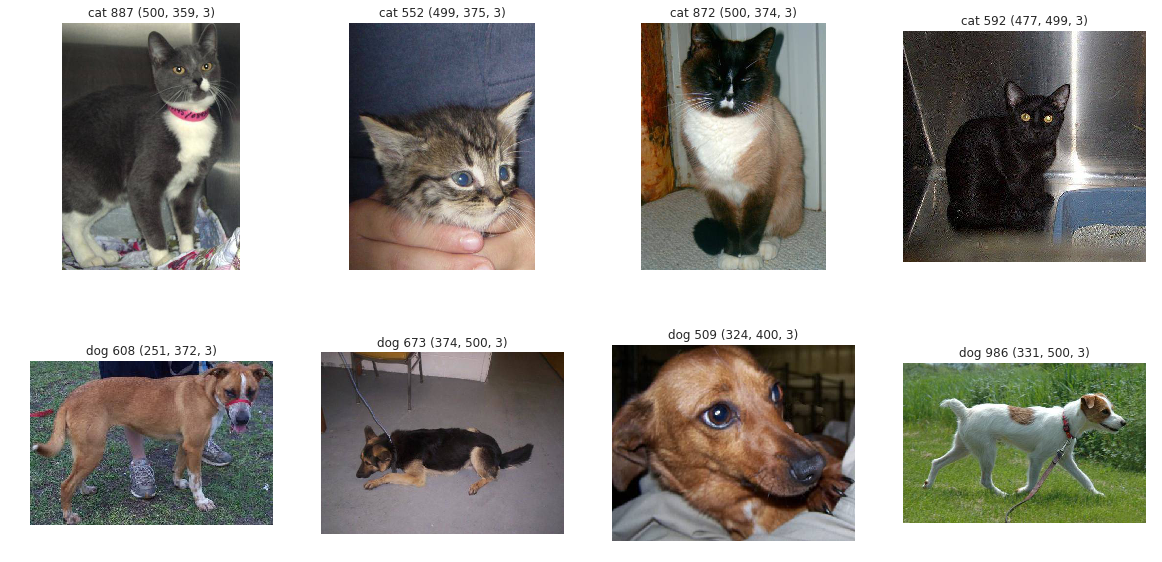

In [7]:
fig=plt.figure(figsize=(20, 10),facecolor='white')
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    this_img_path = display_images[i - 1]
    fname = os.path.split(this_img_path)[-1]
    name, number = fname.split(".")[:2]
    img=mpimg.imread(this_img_path)
    this_ax = fig.add_subplot(rows, columns, i)

    this_ax.set_title("{} {} {}".format(name, number, img.shape,))
    plt.imshow(img)
    plt.axis("off")
plt.show()


<h4>Image flow generators</h4>

In [8]:
from keras.preprocessing import image as image_utils

# Training generator - Augmentation
train_datagen = image_utils.ImageDataGenerator(rescale=1/255,
                                              rotation_range = 40,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2,
                                              shear_range = 0.2,
                                              zoom_range= 0.2,
                                              horizontal_flip=True)

# Training generator - Simple
train_datagen = image_utils.ImageDataGenerator(rescale=1/255)

# Training images
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
);

# Validation images
validation_datagen = ks.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    path_val,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
);

print("Training: {} files over {} classes, resized to {}".format(
    len(train_generator.filenames),
    train_generator.num_classes,
    train_generator.target_size,
    ))

print("Validation: {} files over {} classes, resized to {}".format(
    len(validation_generator.filenames),
    validation_generator.num_classes,
    validation_generator.target_size,
    ))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Training: 2000 files over 2 classes, resized to (150, 150)
Validation: 1000 files over 2 classes, resized to (150, 150)


<h4>Define the network</h4>

In [9]:
model = ks.models.Sequential()

model.add(ks.layers.Conv2D(32, (3,3), activation = "relu", input_shape=(150,150,3)))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(64, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(128, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(128, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Flatten()) # This is just a reshape!

model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(512,activation="relu"))
model.add(ks.layers.Dense(1,activation="sigmoid"))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [40]:
ks.utils.plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [11]:
model.compile(   
    optimizer = ks.optimizers.RMSprop(lr=0.0001),
    loss= ks.losses.binary_crossentropy,
    metrics= ["accuracy"],
)

In [35]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = 50,
    )

Epoch 1/30
100/100 [==============================] - 99s 987ms/step - loss: 0.6283 - acc: 0.6465 - val_loss: 0.6247 - val_acc: 0.6470
Epoch 2/30
100/100 [==============================] - 111s 1s/step - loss: 0.5911 - acc: 0.6725 - val_loss: 0.6262 - val_acc: 0.6530
Epoch 3/30
100/100 [==============================] - 116s 1s/step - loss: 0.5683 - acc: 0.7015 - val_loss: 0.5865 - val_acc: 0.6700
Epoch 4/30
100/100 [==============================] - 109s 1s/step - loss: 0.5481 - acc: 0.7145 - val_loss: 0.6396 - val_acc: 0.6590
Epoch 5/30
100/100 [==============================] - 110s 1s/step - loss: 0.5279 - acc: 0.7410 - val_loss: 0.5713 - val_acc: 0.6870
Epoch 6/30
100/100 [==============================] - 110s 1s/step - loss: 0.5132 - acc: 0.7365 - val_loss: 0.5890 - val_acc: 0.6800
Epoch 7/30
100/100 [==============================] - 108s 1s/step - loss: 0.4964 - acc: 0.7570 - val_loss: 0.5706 - val_acc: 0.6830
Epoch 8/30
100/100 [==============================] - 107s 1s/step 

# Save the model, history, weights

In [90]:
# Save model to h5
path_h5_weights = r"saved_model_weights.hdf5"
model.save_weights(path_h5_weights)
print("Saved model weights to disk")

Saved model weights to disk


In [91]:
# Save model architecture to json
json_path = r"saved_model_architecture.json"

# serialize model to JSON
model_json = model.to_json()

# Write
with open(json_path, "w") as json_file:
    json_file.write(model_json)

History object

In [93]:
history_dict = copy.deepcopy(history.__dict__) # This stores validation_data, model, params, epoch, history
# THEREFORE history.history = history_dict['history'] -> redundant! 

print("Saving history.__dict__, but without the [model]=ks.model.Sequential ")
print()
for k in history_dict:
    print(k, type(history_dict[k]))

path_history = r"saved_model_history.json"
#print(type(history_dict))

with open(path_history, 'w') as fp:
    json_string = json.dump(history_dict,fp)
#history.history

Saving history.__dict__, but without the [model]=ks.model.Sequential 

validation_data <class 'NoneType'>
params <class 'dict'>
epoch <class 'list'>
history <class 'dict'>


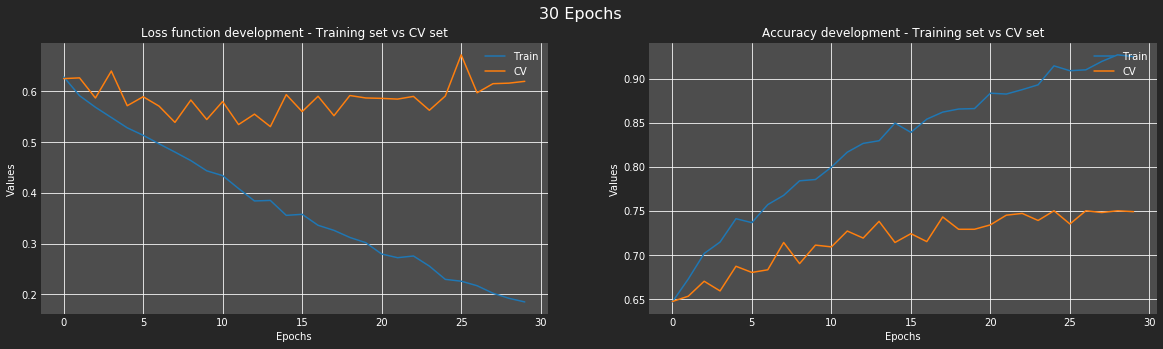

In [38]:
model_title = "30 Epochs"
def plot_hist(history_dict):
    #fig = plt.figure(figsize=(5,4))
    #fig=plt.figure(figsize=(20, 10),facecolor='white')

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='white')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='0.15')
    
    ax1.plot(history_dict['epoch'],  history_dict['history']['loss'],label="Train")
    ax1.plot(history_dict['epoch'],  history_dict['history']['val_loss'],label="CV")
    ax1.set_title("Loss function development - Training set vs CV set")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Values')
    
    ax2.plot(history_dict['epoch'],  history_dict['history']['acc'],label="Train")
    ax2.plot(history_dict['epoch'],  history_dict['history']['val_acc'],label="CV")
    ax2.set_title("Accuracy development - Training set vs CV set")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Values')
    
    plt.suptitle(model_title, fontsize=16)
    
    plt.show()

plot_hist(history_dict)

OTHER

In [ ]:
# 
# import matplotlib.pyplot as plt  
   
 
 # code for building your model  

 # train your model  
 history = model.fit(train_data, train_labels,  
                     nb_epoch=nb_epoch, batch_size=32,  
                     validation_data=(validation_data, validation_labels))  
   
 print(history.history.keys())  
   
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['acc'])  
 plt.plot(history.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show()  